In [3]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import interp1d

nproc = 4
if nproc > 1:
    from pathos.multiprocessing import ProcessPool as Pool

In [4]:
with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl20/joined_vtk/IntSh2-p1.0058.vtk.pkl', 'rb') as f:
    data = pkl.load(f)[0]

In [5]:
data.keys()

dict_keys(['Time', 'x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3', 'vel_tot', 'gamma', 'Bcc_tot', 'Bcc_fluid_0', 'Bcc_fluid_1', 'Bcc_fluid_2', 'Bcc_fluid_3', 'Bcc_fluid_tot', 'Bcc_fluid_tot_vsZ', 'plasma_beta', 'magnetization', 'enthalpy', 'internal_energy', 'internal_energy_vsZ', 'j_nu', 'j_nu_vsZ', 'alpha_nu', 'alpha_nu_vsZ', 'j_over_alpha_nu', 'j_over_alpha_nu_vsZ', 'flux_density', 'flux_density_vsZ', 'spectrum', 'ddt_internal_energy', 'ddt_internal_energy_vsZ'])

In [109]:
def _vector_orientation (vectors):
    '''Returns orientation phi (Arc tan(y/x)) of the vector field.'''
    result = np.arctan(vectors[...,1] / vectors[...,0])
    result = np.where(
        vectors[...,0] > 0,
        result,
        result - np.pi
    )
    result = np.mod(result, 2.*np.pi)
    return result

# we look at Bfield in counterclockwise manner, shifting by (dx,dy)
# note the margin to ensure periodicity
_phi_angles = tuple(np.arange(-0.75*np.pi, 2.75*np.pi, 0.25*np.pi))
_shifts = (
    (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1)
)
def _bfield_angles (bfield, bfield_phi):
    '''For each cell, we limit ourselves to the three neighbours closest to the direction of Bfield in that cell. Then, we report the angles between center cell's Bfield and Bfield at these neighbours.'''
    # calculate which neighbouring cells are closest to where Bfield is pointing
    direction_distances = np.repeat(np.expand_dims(bfield_phi,-1),len(_phi_angles), axis=-1) - _phi_angles
    direction_idxs = np.argpartition(
        np.reshape(np.abs(direction_distances), (-1,len(_phi_angles))),
        3, axis=-1
    )[...,:3]
    direction_idxs = np.reshape(direction_idxs, (*(direction_distances.shape[:-1]),3))
    np.sort(direction_idxs, axis=-1)
    direction_distances = np.take_along_axis(
        direction_distances,
        direction_idxs,
        axis=-1
    )
    # calculate angles between Bfield vectors
    shift_vectors = np.take(
        np.array(_shifts),
        direction_idxs.flatten(),
        axis=0
    )
    shift_vectors = np.reshape(np.array(
        shift_vectors
    ), (*(bfield_phi.shape),3,2))
    shift_vectors = np.transpose(shift_vectors, (-2,-1,0,1))
    indices = np.meshgrid(range(bfield.shape[0]), range(bfield.shape[1]), indexing='ij')
    indices = np.stack(indices)
    indices = np.stack(3*[indices,])[...,1:-1,1:-1]
    rolled_indices = indices + shift_vectors
    bfield_rolled = np.array([
        bfield[i,j] for i,j in rolled_indices
    ])
    bfield_here = np.stack(3*[bfield[...,1:-1,1:-1,:],])
    bfield_angles = np.arccos(
        np.sum(
            bfield_here * bfield_rolled, axis=-1
        ) / np.sqrt(np.sum(bfield_here**2, -1) * np.sum(bfield_rolled**2, -1))
    )
    bfield_angles = np.transpose(np.swapaxes(bfield_angles, 0,-1), (1,0,2))
    return direction_distances, bfield_angles
    
def bfield_curvature (data):
    # collect bfields as vectors
    bfield = np.swapaxes(np.array((
        data['Bcc_fluid_1'],
        data['Bcc_fluid_2'],
        #data['Bcc_fluid_3'], # == 0
    )), 0,-1)
    # at each cell, collect angles between the cell's Bfield direction, and Bfield directions in the neighbouring cells
    print('Calculating angles.. ', end='', flush=True)
    bfield_phi = _vector_orientation(bfield)[1:-1,1:-1]
    direction_distance, bfield_angles = _bfield_angles(bfield, bfield_phi)
    print('done.', flush=True)
    # now, interpolate these values as a function of position angle
    # we'll use simple piecewise parabolic interpolation (y = ax2+bx+c)
    print('Interpolating.. ', end='', flush=True)
    x,y = direction_distance, bfield_angles
    a = ( 1./(x[...,2]-x[...,0]) ) * ( (y[...,2]-y[...,1])/(x[...,2]-x[...,1]) - (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) )
    b = (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) - a*(x[...,0]-x[...,1])
    c = y[...,0] - a*x[...,0]**2 - b*x[...,0]
    bfield_rotation = c
    del bfield, direction_distance, bfield_angles, x,y, a,b
    print('Calculating curvature radius.. ', end='', flush=True)
    # we also need a length scale, we take it from the square-neighbourhood of our bfield
    vectors = np.stack((
        np.cos(bfield_phi), np.sin(bfield_phi)
    ))
    # normalize so that one coordinate ==1 (i.e., we're on a unit square)
    vectors /= np.where(
        vectors[0] > vectors[1],
        vectors[0],
        vectors[1]
    )
    length = np.sqrt(np.sum(
        vectors**2, axis=0
    ))
    del vectors
    # calculate curvature radius
    curvature = bfield_rotation / length
    print('done.', flush=True)
    
    return np.transpose(curvature)

In [110]:
curvature = bfield_curvature(data)

Calculating angles.. 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctan
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


done.
Interpolating.. 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in arccos


Calculating curvature radius.. 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater


done.
(1022, 8190)


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'vlim', 'bins'
  import sys


<Figure size 1080x360 with 0 Axes>

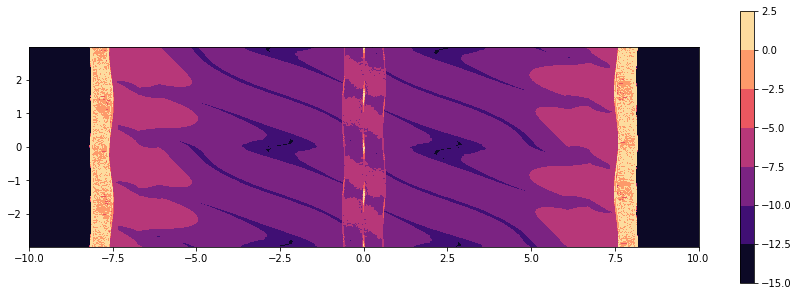

In [111]:
plt.figure(figsize=(15,5))
plt.contourf(
    data['x1v'][1:-1], data['x2v'][1:-1],
    np.where(curvature > np.exp(-15), np.log(curvature), -15),
    vlim=(-15,0),
    bins=128,
    cmap='magma')
plt.xlim(-10,10)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show(); plt.close()